<a href="https://colab.research.google.com/github/RamezNasser5/TweeterEmoji/blob/main/Tweeter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import string
import nltk
import joblib
# Download the WordNet resource
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# read data
df_train = pd.read_csv('/content/twitter_training.csv')
df_val = pd.read_csv('/content/twitter_validation.csv')
# concatenate data
df = pd.concat([df_train, df_val], ignore_index=False)
df.head()

2401  Borderlands  Positive  \
0  2401.0  Borderlands  Positive   
1  2401.0  Borderlands  Positive   
2  2401.0  Borderlands  Positive   
3  2401.0  Borderlands  Positive   
4  2401.0  Borderlands  Positive   

  im getting on borderlands and i will murder you all ,  3364 Facebook  \
0  I am coming to the borders and I will kill you...      NaN      NaN   
1  im getting on borderlands and i will kill you ...      NaN      NaN   
2  im coming on borderlands and i will murder you...      NaN      NaN   
3  im getting on borderlands 2 and i will murder ...      NaN      NaN   
4  im getting into borderlands and i can murder y...      NaN      NaN   

  Irrelevant  \
0        NaN   
1        NaN   
2        NaN   
3        NaN   
4        NaN   

  I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom‚Äôs great auntie as ‚ÄòHayley can‚Äôt get out of bed‚Äô and told to his grandma, who now thinks I‚Äôm a lazy, terrible person ü§£  
0                                                NaN                                                                                                                                                                                                  
1                                                NaN                                                                                                                                                                                                  
2                                                NaN                                                                                                                                                                                                  
3                                                NaN                                                                                                                                                                                                  
4                                                NaN

In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 75680 entries, 0 to 998
Data columns (total 8 columns):
 #   Column                                                                                                                                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                                                                                                                                              --------------  -----  
 0   2401                                                                                                                                                                                                                                                74681 non-null  float64
 1   Borderlands                                                                

In [7]:
# Remove unnecessary columns
columns_to_drop = ['2401', '3364', 'Facebook', 'Irrelevant',
                   'I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom‚Äôs great auntie as ‚ÄòHayley can‚Äôt get out of bed‚Äô and told to his grandma, who now thinks I‚Äôm a lazy, terrible person ü§£']
df = df.drop(columns_to_drop, axis=1)

# Rename columns
df = df.rename(columns={'im getting on borderlands and i will murder you all ,': 'Tweet', 'Positive': 'Sentiment', 'Borderlands':"Branch"})
df.head()

Branch Sentiment                                              Tweet
0  Borderlands  Positive  I am coming to the borders and I will kill you...
1  Borderlands  Positive  im getting on borderlands and i will kill you ...
2  Borderlands  Positive  im coming on borderlands and i will murder you...
3  Borderlands  Positive  im getting on borderlands 2 and i will murder ...
4  Borderlands  Positive  im getting into borderlands and i can murder y...

In [8]:
# check missing values
print(df.isnull().sum())

Branch        999
Sentiment     999
Tweet        1685
dtype: int64


In [9]:
# remove missing values
df.dropna(inplace=True)
# check missing values
df.isnull().sum()

Branch       0
Sentiment    0
Tweet        0
dtype: int64

In [10]:
# check duplicate values
df.duplicated().sum()

3038

In [11]:
# remove duplicate values
remove_duplicates = df.drop_duplicates()
df = remove_duplicates
# check duplicate values
df.duplicated().sum()

0

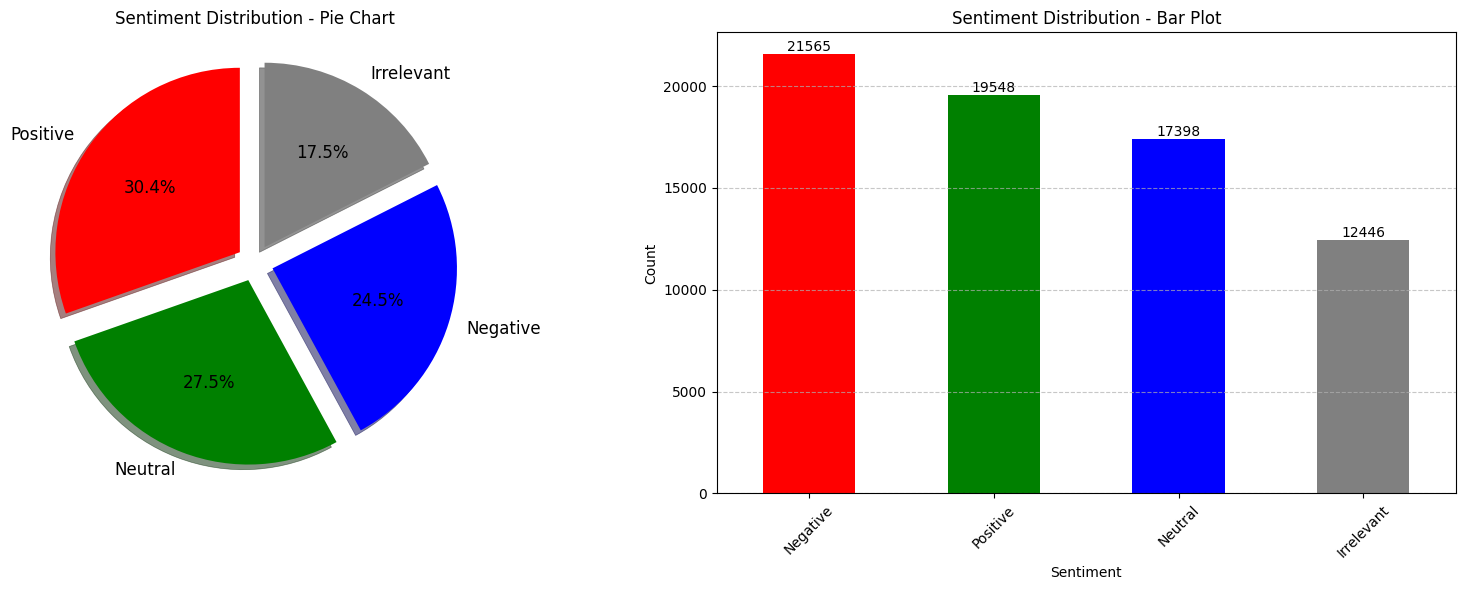

In [12]:
# Define custom colors
colors = ['red', 'green', 'blue', 'gray']

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plotting pie chart for sentiment distribution with custom colors
axs[0].pie(df['Sentiment'].value_counts(), labels=df['Sentiment'].unique(), autopct='%1.1f%%',
            startangle=90, wedgeprops={'linewidth': 0.5}, textprops={'fontsize': 12},
            explode=[0.1, 0.1, 0.1, 0.1], colors=colors, shadow=True)
axs[0].set_title('Sentiment Distribution - Pie Chart')

# Plotting bar plot for sentiment distribution
axs[1] = df['Sentiment'].value_counts().plot(kind='bar', color=colors, ax=axs[1])
axs[1].set_title('Sentiment Distribution - Bar Plot')
axs[1].set_xlabel('Sentiment')
axs[1].set_ylabel('Count')
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# Add text on top of each bar in the bar plot
for p in axs[1].patches:
    axs[1].annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

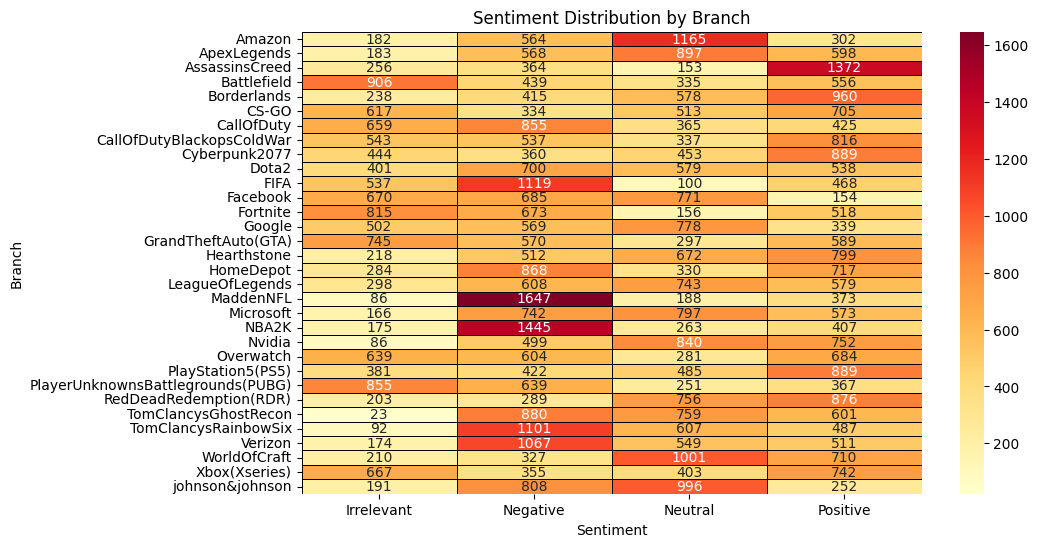

In [13]:
# Create cross-tabulation table in plot
plt.figure(figsize=(10, 6))
count_table = pd.crosstab(index=df['Branch'], columns=df['Sentiment'])
sns.heatmap(count_table, cmap='YlOrRd', annot=True, fmt='d',linewidths=0.5, linecolor='black')
plt.title('Sentiment Distribution by Branch')
plt.xlabel('Sentiment')
plt.ylabel('Branch')
plt.show()

In [14]:
# Display minimum and maximum values for each sentiment for each branch
for sentiment in count_table.columns:
    min_branch = count_table[sentiment].idxmin()
    max_branch = count_table[sentiment].idxmax()
    min_val = count_table[sentiment].min()
    max_val = count_table[sentiment].max()
    print(f"Sentiment '{sentiment}':")
    print(f"  Minimum value '{min_val}' at Branch '{min_branch}'")
    print(f"  Maximum value '{max_val}' at Branch '{max_branch}'\n")

Sentiment 'Irrelevant':
  Minimum value '23' at Branch 'TomClancysGhostRecon'
  Maximum value '906' at Branch 'Battlefield'

Sentiment 'Negative':
  Minimum value '289' at Branch 'RedDeadRedemption(RDR)'
  Maximum value '1647' at Branch 'MaddenNFL'

Sentiment 'Neutral':
  Minimum value '100' at Branch 'FIFA'
  Maximum value '1165' at Branch 'Amazon'

Sentiment 'Positive':
  Minimum value '154' at Branch 'Facebook'
  Maximum value '1372' at Branch 'AssassinsCreed'



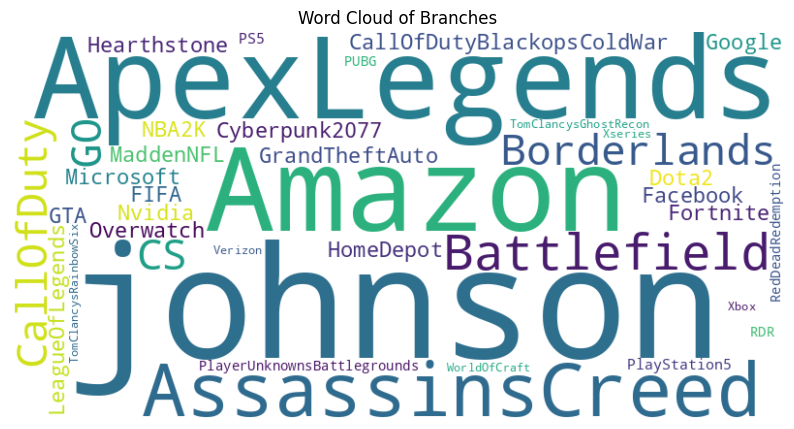

In [15]:
# Convert branches to a single string
branches_text = ' '.join(count_table.index)

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(branches_text)

# Plot word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Branches')
plt.axis('off')
plt.show()

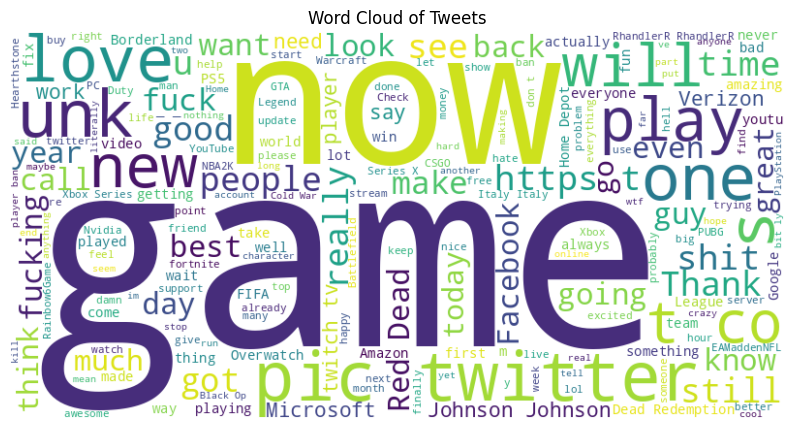

In [16]:
# Concatenate all tweets into a single string
all_tweets_text = ' '.join(df['Tweet'])

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tweets_text)

# Plot word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Tweets')
plt.axis('off')
plt.show()

In [17]:
def filter_non_string(df, column):
    """
    Filter out rows with non-string values in the specified column.
    Convert non-string values to strings.
    """
    df = df.dropna(subset=[column])
    df[column] = df[column].astype(str)
    return df

In [18]:
def normalize_text(text):
    """Convert text to lowercase to ensure consistency across the corpus."""
    return text.lower()

In [19]:
def remove_html_tags(text):
  """Remove HTML tags from the text."""
  return re.sub(r'<.*?>','',text)

In [20]:
def remove_urls(text):
    """Remove URLs or hyperlinks from the text."""
    return re.sub(r'http\S+|www\S+', '', text)

In [21]:
def remove_numbers(text):
    """Exclude numerical digits from the text."""
    return re.sub(r'\d+', '', text)

In [22]:
def remove_punctuation(text):
    """Remove punctuation marks from the text."""
    return text.translate(str.maketrans('', '', string.punctuation))

In [23]:
def tokenize_text(text):
    """Split the text into individual words or tokens."""
    return word_tokenize(text)

In [24]:
def remove_stopwords(tokens):
    """Eliminate common stopwords from the tokenized text."""
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

In [25]:
import re

def remove_emojis(text):
    """Remove emojis from the text."""
    if isinstance(text, str):
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002500-\U00002BEF"  # chinese char
                                   u"\U00002702-\U000027B0"
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   u"\U0001f926-\U0001f937"
                                   u"\U00010000-\U0010ffff"
                                   u"\u2640-\u2642"
                                   u"\u2600-\u2B55"
                                   u"\u200d"
                                   u"\u23cf"
                                   u"\u23e9"
                                   u"\u231a"
                                   u"\ufe0f"  # dingbats
                                   u"\u3030"
                                   "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    else:
        return text

In [26]:
def vectorize_data(text_data):
    # Join the tokenized text into strings
    text_data_strings = [" ".join(tokens) for tokens in text_data]
    # Initialize TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer()
    # Fit and transform the text data to generate TF-IDF vectors
    tfidf_vectors = tfidf_vectorizer.fit_transform(text_data_strings)
    return tfidf_vectors, tfidf_vectorizer

In [27]:
def preprocess_text(df):
    df = filter_non_string(df, 'Tweet')
    df['Tweet'] = df['Tweet'].apply(normalize_text)
    df['Tweet'] = df['Tweet'].apply(remove_html_tags)
    df['Tweet'] = df['Tweet'].apply(remove_urls)
    df['Tweet'] = df['Tweet'].apply(remove_numbers)
    df['Tweet'] = df['Tweet'].apply(remove_punctuation)
    df['Tweet'] = df['Tweet'].apply(tokenize_text)
    df['Tweet'] = df['Tweet'].apply(remove_stopwords)
    df['Tweet'] = df['Tweet'].apply(remove_emojis)
    return df

# Usage:
df_processed = preprocess_text(df)

In [28]:
# df_processed contains preprocessed text data
# Convert list of words into a single string for each entry in 'Tweet' column
df_processed['Tweet'] = df_processed['Tweet'].apply(lambda x: ' '.join(x))

# Split data into features (X) and target (y)
X = df_processed['Tweet']  # Features
y = df_processed['Sentiment']  # Target

# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (56765,)
Shape of X_test: (14192,)
Shape of y_train: (56765,)
Shape of y_test: (14192,)


In [29]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_tfidf, y_train)

# Predict on the testing data
y_pred = rf_classifier.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9062147688838782


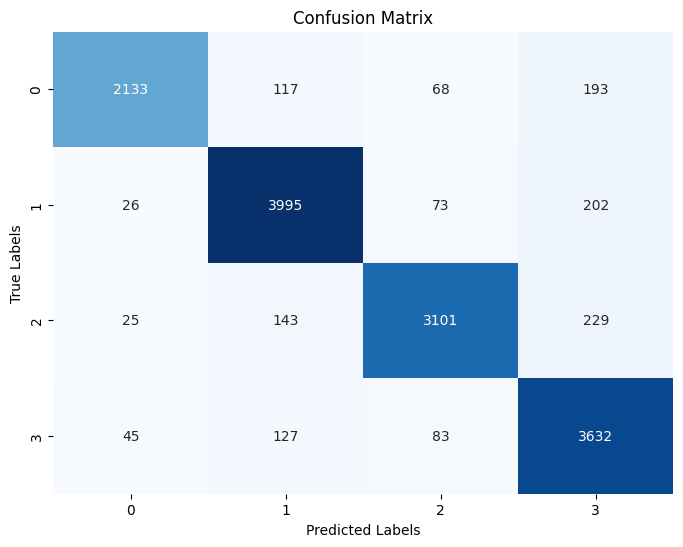

Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.96      0.85      0.90      2511
    Negative       0.91      0.93      0.92      4296
     Neutral       0.93      0.89      0.91      3498
    Positive       0.85      0.93      0.89      3887

    accuracy                           0.91     14192
   macro avg       0.91      0.90      0.91     14192
weighted avg       0.91      0.91      0.91     14192



In [30]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a classification report
class_report = classification_report(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print classification report
print("Classification Report:")
print(class_report)

In [31]:
# Print some actual vs predicted labels along with tweet text
print("Actual vs Predicted Labels with Tweet Text:")
for tweet, actual_label, predicted_label in zip(X_test[:10], y_test[:10], y_pred[:10]):
    print("Tweet:", tweet)
    print("Actual Label:", actual_label)
    print("Predicted Label:", predicted_label)
    print("-----------------------")

Actual vs Predicted Labels with Tweet Text:
Tweet: women please work stores like circuit home hardware get bored condescending men thinking ‚Äô know another screw
Actual Label: Positive
Predicted Label: Negative
-----------------------
Tweet: zai absolute beast reddit fe
Actual Label: Neutral
Predicted Label: Neutral
-----------------------
Tweet: hard fought indeed ‚Ä¶
Actual Label: Neutral
Predicted Label: Neutral
-----------------------
Tweet: rhandlerr ‚Äô superstar solo wins criminal deserved pictwittercomhilloxffi
Actual Label: Irrelevant
Predicted Label: Irrelevant
-----------------------
Tweet: ea eamaddennfl recent announcement ea locked another long term contract nfl remarkably disrespectful fans madden years allow competition madden longer quality
Actual Label: Negative
Predicted Label: Negative
-----------------------
Tweet: first played apex got wave happiness brings back
Actual Label: Positive
Predicted Label: Positive
-----------------------
Tweet: speed better ever howe

In [32]:
import joblib

# Save the trained model
joblib.dump(rf_classifier, 'rf_model.pkl')

['rf_model.pkl']

In [33]:
# Load the saved model
Tweet_Sentiment_Ai = joblib.load('rf_model.pkl')

# Define a mapping between sentiment labels and emojis
sentiment_emojis = {
    'Positive': 'üòÑ',
    'Negative': 'üòû',
    'Neutral': 'üòê',
    'Irrelevant': 'ü§∑‚Äç‚ôÇÔ∏è'
}

# Example tweets
example_tweets = [
    "I just finished playing Borderlands and it was absolutely amazing! Can't wait for the next one!",
    "I'm really disappointed with the latest Borderlands update. It ruined the game for me.",
    "Haven't played Borderlands in a while. Need to catch up on the latest updates.",
    "Just saw a funny cat video while searching for Borderlands gameplay. Cats always cheer me up!"
]


# Transform example tweets into TF-IDF features
example_tweets_tfidf = vectorizer.transform(example_tweets)

# Predict sentiment for example tweets
predictions = Tweet_Sentiment_Ai.predict(example_tweets_tfidf)

# Print the predicted sentiment and corresponding emoji for each example tweet
for tweet, prediction in zip(example_tweets, predictions):
    sentiment = prediction
    emoji = sentiment_emojis[sentiment]  # Get the emoji directly from the mapping without a default value
    print("Tweet:", tweet)
    print("Sentiment:", sentiment)
    print("Emoji:", emoji)
    print()

Tweet: I just finished playing Borderlands and it was absolutely amazing! Can't wait for the next one!
Sentiment: Positive
Emoji: üòÑ

Tweet: I'm really disappointed with the latest Borderlands update. It ruined the game for me.
Sentiment: Negative
Emoji: üòû

Tweet: Haven't played Borderlands in a while. Need to catch up on the latest updates.
Sentiment: Neutral
Emoji: üòê

Tweet: Just saw a funny cat video while searching for Borderlands gameplay. Cats always cheer me up!
Sentiment: Neutral
Emoji: üòê

